In [1]:
#create dictionaries of data with exposure as keys
stdDict1 = {}
meanDict1 = {}
varDict1 = {}

In [2]:
#setup
from FrontPanelAPI import ok
import time
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

dev = ok.okCFrontPanel()
deviceCount = dev.GetDeviceCount()
for i in range(deviceCount):
    print 'Device[{0}] Model: {1}'.format(i, dev.GetDeviceListModel(i))
    print 'Device[{0}] Serial: {1}'.format(i, dev.GetDeviceListSerial(i))

dev = ok.okCFrontPanel()
dev.OpenBySerial("")
dev.ConfigureFPGA("ok_imager.bit")

Device[0] Model: 21
Device[0] Serial: 1631000FBO


0

In [3]:
#please close aperture

In [8]:
#grab 100 frames with aperture closed to obtain offset
dev = ok.okCFrontPanel()
deviceCount = dev.GetDeviceCount()
for i in range(deviceCount):
    print 'Device[{0}] Model: {1}'.format(i, dev.GetDeviceListModel(i))
    print 'Device[{0}] Serial: {1}'.format(i, dev.GetDeviceListSerial(i))

dev = ok.okCFrontPanel()
dev.OpenBySerial("")
dev.ConfigureFPGA("ok_imager.bit")
if dev.IsFrontPanelEnabled():
    row = 160
    N_adc = 4
    N_adcCh = 3
    N_mux = 46
    col = N_adc*N_adcCh*N_mux
    datain128 = bytearray(262144)
    datain1 = bytearray(88320)
    im = np.zeros((row ,col), np.uint8)
    im1 = np.zeros((79 ,60), np.uint8)
    im2 = np.zeros((79 ,60), np.uint8)
    
    exp =3.0
    exposure = int(10**exp)
    
    while exp<4.7:
        print exposure
        offset1 = np.zeros((79,60))
        elsecounter = 0   
        rep = 0
        dev.SetWireInValue(0x11,exposure)
        dev.SetWireInValue(0x12,1)
        dev.SetWireInValue(0x13,0)
        dev.SetWireInValue(0x14,0)
        dev.SetWireInValue(0x15, 0xfff003ff)
        dev.UpdateWireIns()
        time.sleep(0.01)
        # assert reset signal to initialize the FIFO
        dev.SetWireInValue(0x10, 0xff, 0x01)
        dev.UpdateWireIns()
        # deactivate reset signal and activate counter.
        dev.SetWireInValue(0x10, 0x00, 0x01)
        dev.UpdateWireIns()
        time.sleep(0.1)
        while rep<120:
            dev.UpdateTriggerOuts()
            # If the FIFO is full, read everything and display one frame only
            if dev.IsTriggered(0x6A, 0x01) == True:
                dev.ReadFromPipeOut(0xA0, datain128)
                for i in range(row):
                    for j in range(N_adc):
                        for k in range(N_adcCh):
                            for l in range(N_mux):
                                im[row-1-i][col-1-(j*N_adcCh*N_mux+(2-k)*N_mux+45-l)] = datain128[i*col+l*N_adc*N_adcCh+k*N_adc+j]
                #im = im/255
                im1[:,:] = im[1:80,142:262:2]
                if np.any(im1):
                    rep+=1
                    if rep>20: #to account for noise at the beginning
                        offset1 +=im1

            # If one frame is ready in FIFO
            elif dev.IsTriggered(0x6A, 0x02) == True:
                dev.ReadFromPipeOut(0xA0, datain1)
                for i in range(row):
                    for j in range(N_adc):
                        for k in range(N_adcCh):
                            for l in range(N_mux):
                                im[row-1-i][col-1-(j*N_adcCh*N_mux+(2-k)*N_mux+45-l)] = datain1[i*col+l*N_adc*N_adcCh+k*N_adc+j]
                #im = im/255
                im1[:,:] = im[1:80,142:262:2]
                rep+=1
                if np.any(im1):
                    if rep>20: #to account for noise at the beginning
                        offset1 +=im1
            else:
                elsecounter += 1
                print elsecounter
                if elsecounter>100:
                    elsecounter = 0
                    # assert reset signal to initialize the FIFO
                    dev.SetWireInValue(0x10, 0xff, 0x01)
                    dev.UpdateWireIns()
                    # deactivate reset signal and activate counter.
                    dev.SetWireInValue(0x10, 0x00, 0x01)
                    dev.UpdateWireIns()

            if (rep)%10 ==0:
                print rep 
        offset1= offset1/100
        cv2.imwrite(str(exposure)+'.png',offset1) #save offset images
        exp +=0.05
        exposure = int(10**exp)
else:
    print("FrontPanel host interface not detected.")

Device[0] Model: 21
Device[0] Serial: 1631000FBO
1000
10
20
30
40
50
60
70
80
90
100
110
120
1122
10
20
30
40
50
60
70
80
90
100
110
120
1258
10
20
30
40
50
60
70
80
90
100
110
120
1412
10
20
30
40
50
60
70
80
90
100
110
120
1584
10
20
30
40
50
60
70
80
90
100
110
120
1778
10
20
30
40
50
60
70
80
90
100
110
120
1995
10
20
30
40
50
60
70
80
90
100
110
120
2238
10
20
30
40
50
60
70
80
90
100
110
120
2511
10
20
30
40
50
60
70
80
90
100
110
120
2818
10
20
30
40
50
60
70
80
90
100
110
120
3162
10
20
30
40
50
60
70
80
90
100
110
120
3548
10
20
30
40
50
60
70
80
90
100
110
120
3981
10
20
30
40
50
60
70
80
90
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
100
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
3

110
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
120
44668
1
2
3
10
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
20
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
30
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
4

80
70
80
71
80
72
80
73
80
74
80
75
80
76
80
77
80
78
80
79
80
80
80
81
80
82
80
83
80
84
80
85
80
86
80
87
80
88
80
89
80
90
80
91
80
92
80
93
80
94
80
95
80
96
80
97
80
98
80
99
80
100
80
101
80
80
1
80
2
80
3
80
4
80
5
80
6
80
7
80
8
80
9
80
10
80
11
80
12
80
13
80
14
80
15
80
16
80
17
80
18
80
19
80
20
80
21
80
22
80
23
80
24
80
25
80
26
80
27
80
28
80
29
80
30
80
31
80
32
80
33
80
34
80
35
80
36
80
37
80
38
80
39
80
40
80
41
80
42
80
43
80
44
80
45
80
46
80
47
80
48
80
49
80
50
80
51
80
52
80
53
80
54
80
55
80
56
80
57
80
58
80
59
80
60
80
61
80
62
80
63
80
64
80
65
80
66
80
67
80
68
80
69
80
70
80
71
80
72
80
73
80
74
80
75
80
76
80
77
80
78
80
79
80
80
80
81
80
82
80
83
80
84
80
85
80
86
80
87
80
88
80
89
80
90
80
91
80
92
80
93
80
94
80
95
80
96
80
97
80
98
80
99
80
100
80
101
80
80
1
80
2
80
3
80
4
80
5
80
6
80
7
80
8
80
9
80
10
80
11
80
12
80
13
80
14
80
15
80
16
80
17
80
18
80
19
80
20
80
21
80
22
80
23
80
24
80
25
80
26
80
27
80
28
80
29
80
30
80
31
80
32
80
33
80
34
80
35


In [9]:
#please open aperture and expose camera to even illumination


In [12]:
#create dictionaries of data with exposure as keys
stdDict1 = {}
meanDict1 = {}
varDict1 = {}
#grab 100 frames with aperture open to obtain signal 
#might have to manually change exposure due to issues with camera 
dev = ok.okCFrontPanel()
deviceCount = dev.GetDeviceCount()
for i in range(deviceCount):
    print 'Device[{0}] Model: {1}'.format(i, dev.GetDeviceListModel(i))
    print 'Device[{0}] Serial: {1}'.format(i, dev.GetDeviceListSerial(i))

dev = ok.okCFrontPanel()
dev.OpenBySerial("")
dev.ConfigureFPGA("ok_imager.bit")
if dev.IsFrontPanelEnabled():

    exp =3.0
    exposure = int(10**exp)
    
    while exp<4.7:
        offset1 = cv2.imread(str(int(exposure))+'.png',0)
        row = 160
        N_adc = 4
        N_adcCh = 3
        N_mux = 46
        col = N_adc*N_adcCh*N_mux
        datain128 = bytearray(262144)
        datain1 = bytearray(88320)
        im = np.zeros((row ,col))
        im1 = np.zeros((79 ,60))
        im2 = np.zeros((79 ,60))
        sample1 = np.zeros((79,60))
        sample2 = np.zeros((79,60))
        data1 = np.zeros((100,79,60))
        imgcheck = np.zeros((79,60))
        elsecounter = 0 
        rep = 0
        print exposure
        offset1 = cv2.imread(str(int(exposure))+'.png',0)
        
        dev.SetWireInValue(0x11,exposure)
        dev.SetWireInValue(0x12,1)
        dev.SetWireInValue(0x13,0)
        dev.SetWireInValue(0x14,0)
        dev.SetWireInValue(0x15, 0xfff003ff)
        dev.UpdateWireIns()
        time.sleep(0.01)
        # assert reset signal to initialize the FIFO
        dev.SetWireInValue(0x10, 0xff, 0x01)
        dev.UpdateWireIns()
        # deactivate reset signal and activate counter.
        dev.SetWireInValue(0x10, 0x00, 0x01)
        dev.UpdateWireIns()
        time.sleep(0.1)

        while rep<12:
            dev.UpdateTriggerOuts()
            # If the FIFO is full, read everything and display one frame only
            if dev.IsTriggered(0x6A, 0x01) == True:
                dev.ReadFromPipeOut(0xA0, datain128)
                for i in range(row):
                    for j in range(N_adc):
                        for k in range(N_adcCh):
                            for l in range(N_mux):
                                im[row-1-i][col-1-(j*N_adcCh*N_mux+(2-k)*N_mux+45-l)] = datain128[i*col+l*N_adc*N_adcCh+k*N_adc+j]
                im1[:,:] = im[1:80,142:262:2]
                if np.any(im1):
                    rep+=1
                    if rep==11:
                        sample1 = im1 - offset1
                    elif rep ==12:
                        sample2 = im1 - offset1

            # If one frame is ready in FIFO
            elif dev.IsTriggered(0x6A, 0x02) == True:
                dev.ReadFromPipeOut(0xA0, datain1)
                for i in range(row):
                    for j in range(N_adc):
                        for k in range(N_adcCh):
                            for l in range(N_mux):
                                im[row-1-i][col-1-(j*N_adcCh*N_mux+(2-k)*N_mux+45-l)] = datain1[i*col+l*N_adc*N_adcCh+k*N_adc+j]

                im1[:,:] = im[1:80,142:262:2]
                if np.any(im1):
                    rep+=1
                    if rep==11:
                        sample1 = im1 - offset1
                    elif rep ==12:
                        sample2 = im1 - offset1
            else:
                elsecounter += 1
                print elsecounter
                if elsecounter>100:
                    elsecounter = 0
                    # assert reset signal to initialize the FIFO
                    dev.SetWireInValue(0x10, 0xff, 0x01)
                    dev.UpdateWireIns()
                    # deactivate reset signal and activate counter.
                    dev.SetWireInValue(0x10, 0x00, 0x01)
                    dev.UpdateWireIns()
        #compute the standard deviation and average signal of each pixel 
        mean = np.mean(sample1)
        std = np.std(sample1-sample2)
        var = np.var(sample1-sample2)
        cv2.imwrite(str(exposure)+'test1.png', sample1)#make sure the data is ok
        cv2.imwrite(str(exposure)+'test2.png', sample2)#make sure the data is ok
        stdDict1[exposure] = std
        meanDict1[exposure]= mean
        varDict1[exposure]= var

        exp +=0.05
        exposure = int(10**exp)
    x = np.zeros(len(stdDict1.keys()))
    y = np.zeros(len(stdDict1.keys()))
    i = 0
    for key in sorted(stdDict1.keys()):
        x[i] = math.log(meanDict1[key],10)
        y[i] = math.log(stdDict1[key],10)
        i +=1
    p=np.poly1d(np.polyfit(x,y,1))
    print (np.poly1d(p))
    plt.plot(x, p(x), label = 'fit', linestyle = '-')
    plt.plot(x,y,'o',label = 'data')
    plt.legend()
    plt.show()
else:
    print("FrontPanel host interface not detected.")

Device[0] Model: 21
Device[0] Serial: 1631000FBO
1000
1122
1258
1412
1584
1778
1995
2238
2511
2818
3162
3548
3981
4466
5011
5623
6309
7079
7943
8912
9999
11220
12589
14125
15848
17782
19952
22387
25118
28183
31622
35481
39810
1
44668
50118
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


ValueError: math domain error

In [29]:
#create dictionaries of data with exposure as keys
stdDict1 = {}
meanDict1 = {}
varDict1 = {}
#grab 100 frames with aperture open to obtain signal 
#might have to manually change exposure due to issues with camera 
dev = ok.okCFrontPanel()
deviceCount = dev.GetDeviceCount()
for i in range(deviceCount):
    print 'Device[{0}] Model: {1}'.format(i, dev.GetDeviceListModel(i))
    print 'Device[{0}] Serial: {1}'.format(i, dev.GetDeviceListSerial(i))

dev = ok.okCFrontPanel()
dev.OpenBySerial("")
dev.ConfigureFPGA("ok_imager.bit")
if dev.IsFrontPanelEnabled():

    exp =3.0
    exposure = int(10**exp)
    
    while exp<4.2:
        offset1 = cv2.imread(str(int(exposure))+'.png',0)
        row = 160
        N_adc = 4
        N_adcCh = 3
        N_mux = 46
        col = N_adc*N_adcCh*N_mux
        datain128 = bytearray(262144)
        datain1 = bytearray(88320)
        im = np.zeros((row ,col))
        im1 = np.zeros((79 ,60))
        im2 = np.zeros((79 ,60))
        sample1 = np.zeros((79,60))
        sample2 = np.zeros((79,60))
        data1 = np.zeros((100,79,60))
        imgcheck = np.zeros((79,60))
        elsecounter = 0 
        rep = 0
        print exposure
        offset1 = cv2.imread(str(int(exposure))+'.png',0)
        
        dev.SetWireInValue(0x11,exposure)
        dev.SetWireInValue(0x12,1)
        dev.SetWireInValue(0x13,0)
        dev.SetWireInValue(0x14,0)
        dev.SetWireInValue(0x15, 0xfff003ff)
        dev.UpdateWireIns()
        time.sleep(0.01)
        # assert reset signal to initialize the FIFO
        dev.SetWireInValue(0x10, 0xff, 0x01)
        dev.UpdateWireIns()
        # deactivate reset signal and activate counter.
        dev.SetWireInValue(0x10, 0x00, 0x01)
        dev.UpdateWireIns()
        time.sleep(0.1)

        while rep<12:
            dev.UpdateTriggerOuts()
            # If the FIFO is full, read everything and display one frame only
            if dev.IsTriggered(0x6A, 0x01) == True:
                dev.ReadFromPipeOut(0xA0, datain128)
                for i in range(row):
                    for j in range(N_adc):
                        for k in range(N_adcCh):
                            for l in range(N_mux):
                                im[row-1-i][col-1-(j*N_adcCh*N_mux+(2-k)*N_mux+45-l)] = datain128[i*col+l*N_adc*N_adcCh+k*N_adc+j]
                im1[:,:] = im[1:80,142:262:2]
                if np.any(im1):
                    rep+=1
                    if rep==11:
                        sample1 = im1 - offset1
                    elif rep ==12:
                        sample2 = im1 - offset1

            # If one frame is ready in FIFO
            elif dev.IsTriggered(0x6A, 0x02) == True:
                dev.ReadFromPipeOut(0xA0, datain1)
                for i in range(row):
                    for j in range(N_adc):
                        for k in range(N_adcCh):
                            for l in range(N_mux):
                                im[row-1-i][col-1-(j*N_adcCh*N_mux+(2-k)*N_mux+45-l)] = datain1[i*col+l*N_adc*N_adcCh+k*N_adc+j]

                im1[:,:] = im[1:80,142:262:2]
                if np.any(im1):
                    rep+=1
                    if rep==11:
                        sample1 = im1 - offset1
                        print sample1
                    elif rep ==12:
                        sample2 = im1 - offset1
            else:
                elsecounter += 1
                print elsecounter
                if elsecounter>10:
                    elsecounter = 0
                    # assert reset signal to initialize the FIFO
                    dev.SetWireInValue(0x10, 0xff, 0x01)
                    dev.UpdateWireIns()
                    # deactivate reset signal and activate counter.
                    dev.SetWireInValue(0x10, 0x00, 0x01)
                    dev.UpdateWireIns()
        #compute the standard deviation and average signal of each pixel 
        mean = np.mean(sample1)
        std = np.std(sample1-sample2)
        var = np.var(sample1-sample2)
        cv2.imwrite(str(exposure)+'test1.png', sample1)#make sure the data is ok
        cv2.imwrite(str(exposure)+'test2.png', sample2)#make sure the data is ok
        stdDict1[exposure] = std
        meanDict1[exposure]= mean
        varDict1[exposure]= var

        exp +=0.05
        exposure = int(10**exp)
    x = np.zeros(len(stdDict1.keys()))
    y = np.zeros(len(stdDict1.keys()))
    i = 0
    for key in sorted(stdDict1.keys()):
        x[i] = math.log(meanDict1[key],10)
        y[i] = math.log(stdDict1[key],10)
        i +=1
    p=np.poly1d(np.polyfit(x,y,1))
    print (np.poly1d(p))
    plt.plot(x, p(x), label = 'fit', linestyle = '-')
    plt.plot(x,y,'o',label = 'data')
    plt.legend()
    plt.show()
else:
    print("FrontPanel host interface not detected.")

Device[0] Model: 21
Device[0] Serial: 143400091C
1000
[[  7.   8.   4. ...,   8.  13.   9.]
 [  5.   9.   8. ...,  11.  10.  10.]
 [  7.   7.   8. ...,   8.   5.   9.]
 ..., 
 [  4.   4.   5. ...,   3.   3.   3.]
 [  1.   4.   5. ...,   5.   4.   2.]
 [  3.   2.   3. ...,   3.   3.   2.]]
1122
[[  9.   9.   4. ...,   8.  14.  10.]
 [  5.   9.   8. ...,  12.  11.  12.]
 [  7.   6.   8. ...,   9.   5.   9.]
 ..., 
 [  4.   4.   6. ...,   3.   4.   3.]
 [  2.   5.   5. ...,   5.   4.   3.]
 [  4.   3.   4. ...,   3.   2.   3.]]
1258
[[  8.   9.   5. ...,  10.  15.  11.]
 [  5.  10.   8. ...,  13.  11.  11.]
 [  7.   7.   9. ...,  10.   6.  10.]
 ..., 
 [  4.   4.   6. ...,   3.   4.   4.]
 [  2.   5.   6. ...,   5.   4.   3.]
 [  3.   3.   4. ...,   4.   3.   3.]]
1412
[[  9.  10.   4. ...,  10.  16.  11.]
 [  6.  10.   9. ...,  14.  12.  12.]
 [  8.   7.   9. ...,  10.   6.   9.]
 ..., 
 [  5.   5.   6. ...,   3.   5.   4.]
 [  2.   6.   7. ...,   6.   5.   4.]
 [  4.   3.   4. ...,   4.

ValueError: math domain error

 
0.02129 x - 0.676


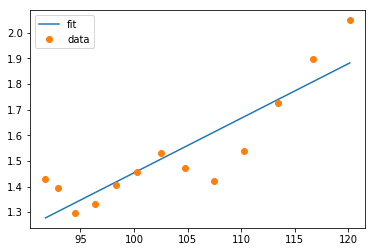

In [50]:
x = np.zeros(len(stdDict1.keys()))
y = np.zeros(len(stdDict1.keys()))
i = 0
for key in sorted(stdDict1.keys()):
    x[i] = meanDict1[key]
    y[i] = varDict1[key]
    i +=1
p=np.poly1d(np.polyfit(x,y,1))
print (np.poly1d(p))
plt.plot(x, p(x), label = 'fit', linestyle = '-')
plt.plot(x,y,'o',label = 'data')
plt.legend()
plt.show()

In [51]:
import pickle

#save dictionaries

with open('stdDict1.pkl', 'wb') as output:
    pickle.dump(stdDict1, output)

with open('meanDict1.pkl', 'wb') as output:
    pickle.dump(meanDict1, output)
    
with open('varDict1.pkl', 'wb') as output:
    pickle.dump(varDict1, output)    


 
0.674 x - 1.267


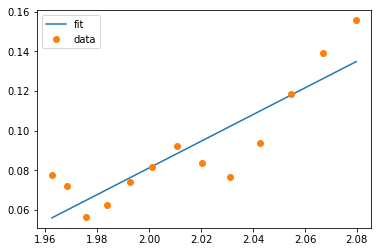

In [52]:
import math
import matplotlib.pyplot as plt
import numpy as np
#load dictionaries to plot data
with open('stdDict1.pkl', "rb") as fp:
    stdDict = pickle.load(fp) 

with open('meanDict1.pkl', "rb") as fp:
    meanDict = pickle.load(fp) 
    
with open('varDict1.pkl', "rb") as fp:
    varDict = pickle.load(fp)   
x = np.zeros(len(stdDict1.keys()))
y = np.zeros(len(stdDict1.keys()))
i = 0
for key in sorted(stdDict1.keys()):
    x[i] = math.log(meanDict1[key],10)
    y[i] = math.log(stdDict1[key],10)
    i +=1
p=np.poly1d(np.polyfit(x,y,1))
print (np.poly1d(p))
plt.plot(x, p(x), label = 'fit', linestyle = '-')
plt.plot(x,y,'o',label = 'data')
plt.legend()
plt.show()